In [2]:
#for paper 3: computation of the sensitivity of the anstisymmetric power spectrum
#from the simulation result
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import time
import sys
import os
import scipy
from scipy.interpolate import interp1d, interp2d
from multiprocessing import Pool, Manager
import antisym_func
import error_bar
from importlib import reload

reload(error_bar)

ModuleNotFoundError: No module named 'antisym_func'

In [5]:
#read in the auto power spectrum, cross power spectrum and the antisymmetric power spectrum 
#read in the simulation result of Tan
file = open('../data/Tan/paz_7.67_384Mpc.txt').read()
#k in h / Mpc, power spectrums in muK^2 (Mpc/h)**3
k_Tan = []; anti_Tan = []; var_anti_Tan = []; sym_Tan = []
N_Tan = []; P_21_Tan =[]; P_CO_Tan = []
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        k_Tan.append(float(i[0])); anti_Tan.append(float(i[1])); sym_Tan.append(float(i[3])) #var_anti.append(i[2])
        P_21_Tan.append(float(i[5])); P_CO_Tan.append(float(i[6])) #N.append(i[4])

#read in the simulation result of Mine
k_simu = []; sym_simu = []; P_21_simu =[]; P_CO_simu = []
file = open('../data/antisym_observability/21cmFAST/P21_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t') 
        k_simu.append(float(i[0])); # Mpc^-1
        P_21_simu.append(float(i[1])) # mK^2 Mpc^-3
#I set k_simu = k_Tan
k_simu = np.array(k_simu[1:]) / antisym_func.hlittle # h / Mpc
P_21_simu = np.array(P_21_simu[1:]) * 1e6 * antisym_func.hlittle**3 # muK^2 (Mpc/h)**3
file = open('../data/antisym_observability/21cmFAST/PCO_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        P_CO_simu.append(float(i[1])) # muK^2 Mpc^-3
P_CO_simu = np.array(P_CO_simu[1:]) * antisym_func.hlittle**3 # muK^2 (Mpc/h)**3
file = open('../data/antisym_observability/21cmFAST/Psym_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        sym_simu.append(float(i[1]))  # muK * mK * Mpc^-3
sym_simu = np.array(sym_simu[1:]) * 1e3 * antisym_func.hlittle**3 # muK^2 (Mpc/h)**3

In [6]:
#the problem here is the bandwidth of the telescopes
def VAR_PkA_HICO_computation(t_total, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, z, kh_array, P_CO_array, P_21_array, Pk_S_array, Pk_A_array):
    """
    t_total : s, the total observation time
    SMOOTHING_Pk : Mpc, the computation box size
    NUM_PATCH : the number of boxes in a survey
    z : the middle redshift of the observation
    kh_array : h/Mpc, the array of the measured scales
    P_CO_array : [muK]^2[Mpc/h]^3, the array of CO auto power spectrums
    P_21_array : [muK]^2[Mpc/h]^3, the array of 21 auto power spectrums
    Pk_S_array : [muK]^2[Mpc/h]^3, the array of 21-CO cross power spectrums
    Pk_A_array : [muK]^2[Mpc/h]^3, the array of 21-CO antisymmetric cross power spectrums
    """
    
    #set the parameters
    Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6 # muK
    Tsys_CO = 25 * 1e6 # muK
    D_21 = 35; D_CO = 15 # meter 
    Omega_beam_21 = (1.22 * error_bar.lambda_21 * (1 + z) / D_21 ) ** 2
    Omega_beam_CO = (1.22 * error_bar.lambda_CO * (1 + z) / D_CO ) ** 2 # radians
    delta_nu_21 = 5.4e-3; delta_nu_CO = 79.3e-3 #MHz
    
    #set the Parameters of telescopes
    if MEASUREMENT == 0: #parameters of SKA1 
        N_feeds_21 = 2 # num of polarizations
        N_feeds_CO = 197 * 2 # num of antennas * num of polarizations
        L_min_21 = 60; L_max_21 = 1000 #m
    elif MEASUREMENT == 1: #parameters of SKA2
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 1970 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    elif MEASUREMENT == 2: #parameters of SKA2-advanced
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 4925 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    
    #SMOOTHING_Pk defines the box size
    Omega_patch = (SMOOTHING_Pk * antisym_func.hlittle / error_bar.X(z)) ** 2
    Omega_survey = NUM_PATCH * Omega_patch
    B_21 = SMOOTHING_Pk * antisym_func.hlittle / error_bar.Y(z, error_bar.nu_21)
    B_CO = SMOOTHING_Pk * antisym_func.hlittle / error_bar.Y(z, error_bar.nu_CO)
    delta_D = SMOOTHING_Pk * antisym_func.hlittle 
    k_limits = error_bar.reliable_k_range(z, Omega_beam_CO, Omega_patch, delta_nu_CO, delta_D, L_min_21, L_max_21, delta_nu_21)
    
    error_auto_CO_array = []; error_auto_21_array = []
    error_PkA_HICO_array = []; error_PkS_HICO_array = []
    VAR_PkA_array = []; S_over_N = []
    for j in range(len(kh_array)):
        kh = kh_array[j]
        delta_kh = kh * 0.1 #k_factor = 1.1 in Zhou's code
        error_auto_CO_array.append(error_bar.error_CO_auto(kh, delta_kh, k_limits, P_CO_array[j], z, Tsys_CO,\
                                    Omega_patch, NUM_PATCH, B_CO, Omega_beam_CO, delta_nu_CO, N_feeds_CO, t_total))
        error_auto_21_array.append(error_bar.error_21_auto(kh, delta_kh, k_limits, P_21_array[j], z, Tsys_21,\
                                    Omega_patch, NUM_PATCH, Omega_beam_21, B_21, N_feeds_21, t_total))
        error_PkA_HICO_array.append(error_bar.error_21_CO_cross(kh, delta_kh, k_limits, Pk_A_array[j], z, Omega_patch, NUM_PATCH, delta_D))
        error_PkS_HICO_array.append(error_bar.error_21_CO_cross(kh, delta_kh, k_limits, Pk_S_array[j], z, Omega_patch, NUM_PATCH, delta_D))
        VAR_PkA_array.append(9/20/np.pi * error_PkA_HICO_array[-1][0] ** 2 + error_auto_21_array[-1][0] * \
                                  error_auto_CO_array[-1][0] - error_PkS_HICO_array[-1][0] ** 2)
        S_over_N.append(abs(anti_Tan[j]) / VAR_PkA_array[j]**0.5)
    
    #compute the confidence
    square_sum = np.sum(np.array(S_over_N)**2)
    free_degree = len(S_over_N)-1
    confidence = error_bar.significance_level(square_sum, free_degree)
    kh_min = kh_array[0]
    kh_max = kh_array[free_degree]
    while free_degree > 1:
        square_sum -= S_over_N[free_degree]**2
        free_degree -= 1 
        temp_confidence = error_bar.significance_level(square_sum, free_degree)
        #print(square_sum, free_degree, temp_confidence)
        if (temp_confidence > confidence):
            confidence = temp_confidence
            kh_max = kh_array[free_degree]
    return VAR_PkA_array, S_over_N, kh_min, kh_max, confidence, error_PkA_HICO_array

In [10]:
t_total = 3000 #hour 
SMOOTHING_Pk = 384 #Mpc
VAR_PkA_array_0, S_over_N_0, k_min_0, kh_max_0, confidence_0, error_PkA_HICO_array = VAR_PkA_HICO_computation(t_total * 3600, SMOOTHING_Pk, 100, 0, 7.67, k_simu, P_CO_simu, P_21_simu, sym_simu, anti_Tan)
error_PkA_HICO_array, anti_Tan

0.14106749262536872 0.014106749262536872 1764748228.8734217 12548.848015180321
0.14106749262536872 0.014106749262536872 1764748228.8734217 12548.848015180321
0.15330825958702063 0.015330825958702063 1764748228.8734217 16107.18616270793
0.15330825958702063 0.015330825958702063 1764748228.8734217 16107.18616270793
0.16938495575221238 0.01693849557522124 1764748228.8734217 21724.386614135023
0.16938495575221238 0.01693849557522124 1764748228.8734217 21724.386614135023
0.18448126843657817 0.018448126843657816 1764748228.8734217 28065.95639299652
0.18448126843657817 0.018448126843657816 1764748228.8734217 28065.95639299652
0.20347890855457224 0.020347890855457226 1764748228.8734217 37660.07809902044
0.20347890855457224 0.020347890855457226 1764748228.8734217 37660.07809902044
0.22509262536873154 0.022509262536873156 1764748228.8734217 50980.82013868175
0.22509262536873154 0.022509262536873156 1764748228.8734217 50980.82013868175
0.24724719764011796 0.024724719764011797 1764748228.8734217 67

([(-9872.012155553515, 12548.848015180321),
  (-7127.095992139785, 16107.18616270793),
  (-4133.444902222704, 21724.386614135023),
  (-3246.4163908506907, 28065.95639299652),
  (-1940.9441761378403, 37660.07809902044),
  (-1206.3621595779887, 50980.82013868175),
  (-979.6607863697639, 67564.27978567492),
  (-502.642344100191, 89691.45300073877),
  (-335.4342791773256, 119349.97318425305),
  (-203.0836635461607, 158940.77578370197),
  (-103.0344692634891, 212648.44223720982),
  (-73.97845696973741, 283262.0943422954),
  (-40.88063761435791, 374837.47095859895),
  (-21.513126370483114, 499076.32302431413),
  (-11.71455750804395, 664779.1320481717),
  (8.78575959966814, 614821.3594882246),
  (7.3803654457664924, 588422.5926420718),
  (3.9491892441050473, 600683.6135916852),
  (2.6654843062709457, 629185.1950804775),
  (1.7721754452404663, 668101.0562165017),
  (1.1334372772672854, 715726.0965155489),
  (0.6088952961434106, 771648.2238811743),
  (0.4353341073157141, 835574.578987105),
  (0

In [1]:
t_total = 3000 #hour 
SMOOTHING_Pk = 384 #Mpc

VAR_PkA_array_0, S_over_N_0, k_min_0, kh_max_0, confidence_0 = VAR_PkA_HICO_computation(t_total * 3600, SMOOTHING_Pk, 75, 0, 7.67, k_simu, P_CO_simu, P_21_simu, sym_simu, anti_Tan)
VAR_PkA_array_1, S_over_N_1, kh_min_1, kh_max_1, confidence_1 = VAR_PkA_HICO_computation(t_total * 3600, SMOOTHING_Pk, 200, 1, 7.67, k_simu, P_CO_simu, P_21_simu, sym_simu, anti_Tan)
VAR_PkA_array_2, S_over_N_2, kh_min_2, kh_max_2, confidence_2 = VAR_PkA_HICO_computation(t_total * 3600, SMOOTHING_Pk, 300, 2, 7.67, k_simu, P_CO_simu, P_21_simu, sym_simu, anti_Tan)

NameError: name 'VAR_PkA_HICO_computation' is not defined

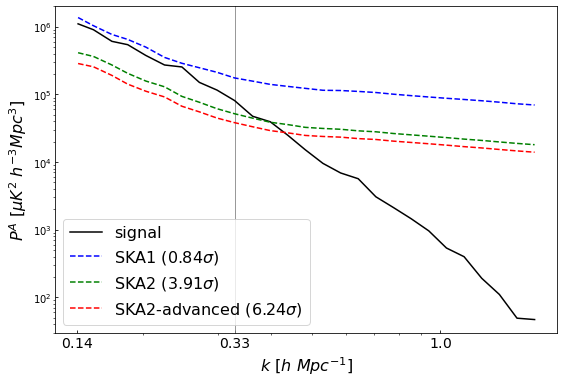

In [71]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(9,6))
fig.subplots_adjust(hspace=0)
axs.loglog(k_simu, -np.array(anti_Tan), color = 'black', label = 'signal')
axs.loglog(k_simu, np.array(VAR_PkA_array_0)**0.5, ls = '--', color = 'blue', label = 'SKA1 (%3.3g$\sigma$)'%confidence_0)
axs.loglog(k_simu, np.array(VAR_PkA_array_1)**0.5, ls = '--', color = 'green', label = 'SKA2 (%3.3g$\sigma$)'%confidence_1)
axs.loglog(k_simu, np.array(VAR_PkA_array_2)**0.5, ls = '--', color = 'red', label = 'SKA2-advanced (%3.3g$\sigma$)'%confidence_2)
axs.vlines(x=kh_max_2,ymin = 1e1,ymax = 1e7, color = 'grey', lw=0.8)
axs.legend(loc = 3, fontsize = 16)
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
axs.set_ylabel(r'$P^A\ [\mu K^2\ h^{-3} Mpc^3]$',fontsize=16)
axs.set_xlabel(r'$k\ [h\ Mpc^{-1}]$',fontsize=16)
axs.tick_params(direction='in',length=3)
axs.set_ylim(3e1, 2e6)
axs.set_xticks([0.14, kh_max_2, 1])
axs.set_xticklabels(['$0.14$', '%2.2g'%kh_max_2,'$1.0$'], fontsize=14)
#axs[1].text(8.3, 0.31,'accel.',fontsize=12); axs[1].text(6.7, 0.3, 'decel.', fontsize = 12)
plt.savefig('../figures/sensitivity_t%05.5g_time%f.png'%(t_total,time.time()), bbox_inches='tight', dpi=200)